# Identify a MHW

In [22]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean

import matplotlib.pyplot as plt
import dask

In [31]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 15  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [32]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e9429d3bc43747d2b3e7ee1703c8bea6/status,


In [2]:
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [10]:
sst = ds_sst.sst.chunk({'time':-1})

In [11]:
sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<rechunk-merge, shape=(50309, 109, 401), dtype=float32, chunksize=(50309, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

In [5]:
#daily clim
clim = sst.groupby('time.dayofyear').mean('time')
clim_std = sst.groupby('time.dayofyear').std('time')
anom = sst.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst.groupby('time.month').mean('time')
mo_clim_std = sst.groupby('time.month').std('time')
mo_anom = sst.groupby('time.month') - mo_clim

In [26]:
q90 = sst.quantile(0.9, dim='time')

In [27]:
q90

<xarray.DataArray 'sst' (latitude: 109, longitude: 401)>
dask.array<getitem, shape=(109, 401), dtype=float64, chunksize=(109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.9

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


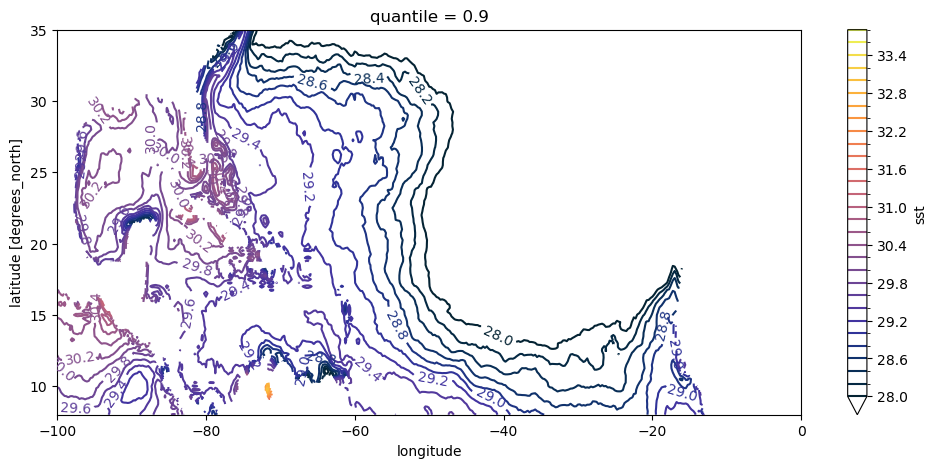

In [28]:
theta_levs = np.arange(28,34,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q90.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

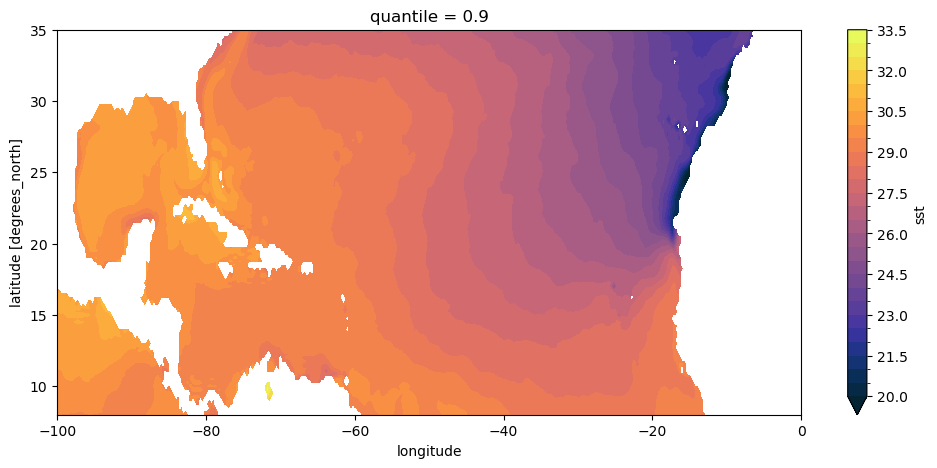

In [29]:
theta_levs = np.arange(20,34,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = q90.plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)

In [35]:
mo_anom_mean = mo_anom.mean(['latitude', 'longitude'])
sst_mean = sst.mean(['latitude', 'longitude'])

In [39]:
mo_anom.latitude.min()

<xarray.DataArray 'latitude' ()>
array(8.)

In [41]:
mo_anom_mean.time[mo_anom_mean>=thr]

IndexError: 3-dimensional boolean indexing is not supported. 

IndexError: 3-dimensional boolean indexing is not supported. 

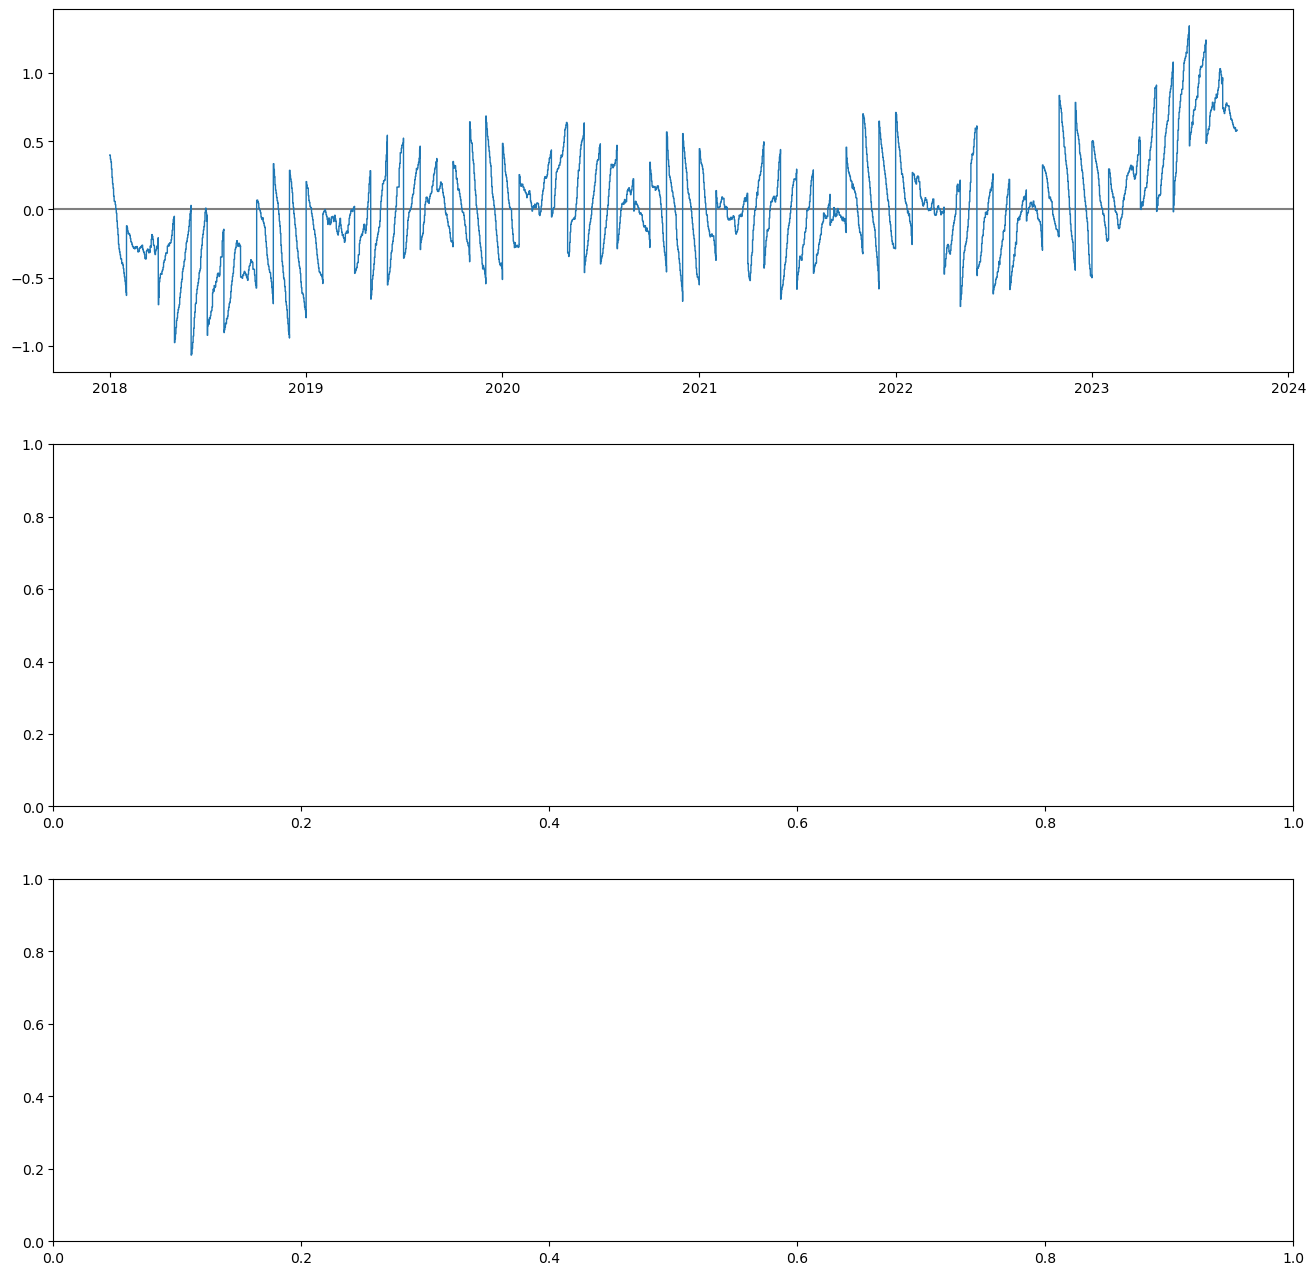

In [43]:
# first, calculate the threshold: 90th percentile
thr = q90
latr = [mo_anom.latitude.min(), mo_anom.latitude.max()] # make sure lat1 < lat2 since no test is done below to simplify the code
lonr = [mo_anom.longitude.min(), mo_anom.longitude.max()] # lon1 < lon2, range -180:180. resolution daily 1km!

fig, axs = plt.subplots(3,1,figsize=(16,16)) # make a figure of 3 vertical panels

# same plot as in our function above, but this time we are plotting the anomalies.
plt.subplot(3,1,1) 
plt.plot(mo_anom.time, mo_anom_mean.data, lw=1)
plt.axhline(y=0, c='k', zorder=0, alpha=0.5) # add a line to highlight the x axis 
a=mo_anom>=thr # select data above the threshold
plt.plot(mo_anom.time[a], mo_anom.data[a],'.r', markersize=3)
# all stuff here to make it look good
plt.ylabel('SST anomalies ($^\circ$C)')
plt.xlabel('Year')
plt.title('Location: '+str(latr)+'$^\circ$N, '+str(lonr)+'$^\circ$W')
plt.grid(True, alpha=0.3)

# Now plot on the original data (not anomalies)
plt.subplot(3,1,2) # second panel
plt.plot(sst.time,sst.data, lw=1)
plt.plot(sst.time[a], sst.data[a],'.r', markersize=3) # plot only the values equal or above threshold
# all stuff here to make it look good
plt.ylabel('SST ($^\circ$C)')
plt.xlabel('Year')
plt.title('Location: '+str(latr)+'$^\circ$N, '+str(lonr)+'$^\circ$W')
plt.grid(True, alpha=0.3)

# plot of marine heatwave days  per year
dts = mo_anom[mo_anom>=thr].time
mhw = dts.groupby('time.year').count()
plt.subplot(3,1,3) # third panel
plt.bar(mhw.year,mhw)
plt.ylabel('No. days SSTa > '+str(np.round(thr,1))+'C')
plt.grid(True, alpha=0.3)
plt.show()

mhw # print the numbers of days

In [ ]:
client.close()
cluster.close()